<a href="https://colab.research.google.com/github/nayonsoso/hg-mldl/blob/main/Ch03_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# k-최근접 이웃 회귀

## 회귀 알고리즘이란?

지도 학습 알고리즘은 크게 분류와 회귀로 나뉜다.

분류는 말 그대로 주어진 데이터를 몇 개의 클래스 중 하나로 분류하는 문제이다. (ex. 주어진 데이터가 도미인가 빙어인가?)

회귀는 임의의 숫자를 예측하는 문제이다.

## k - 최근접 이웃 회귀

2장에서 사용한 k-최근접 이웃 알고리즘을 회귀에도 적용할 수 있다.

k-최근접 이웃 '분류'는 특정 데이터와 가장 근접한 k개 데이터의 타깃 중 어떤 것이 많은지로 분류했고,

k-최근접 이웃 '회귀'는 특정 데이터와 가장 근접한 k개 데이터의 타깃 평균을 사용하여 예측한다.

k개의 가장 가까운 이웃을 참고한는 점에서 같은 원리이다.

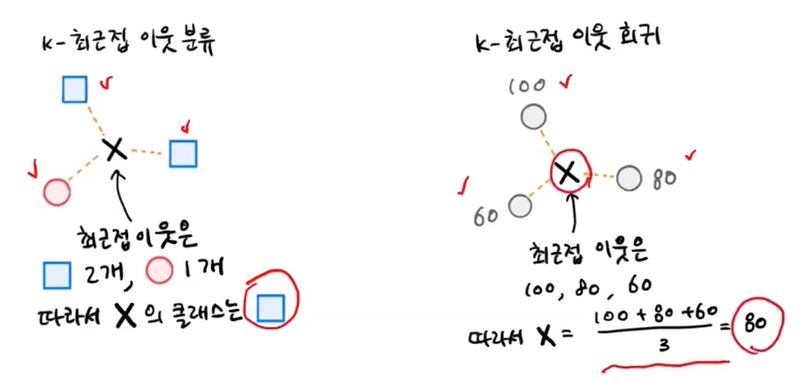

( 출처 : https://youtu.be/0mrLRkgbjA0 )

## 데이터 살펴보기

'길이'를 토대로 '무게'를 예측해야 하므로 길이가 input, 무게가 target의 역할을 한다.

In [ ]:
# numpy 배열 생성
import numpy as np

# perch는 농어라는 뜻
perch_length = np.array(
    [8.4, 13.7, 15.0, 16.2, 17.4, 18.0, 18.7, 19.0, 19.6, 20.0, 
     21.0, 21.0, 21.0, 21.3, 22.0, 22.0, 22.0, 22.0, 22.0, 22.5, 
     22.5, 22.7, 23.0, 23.5, 24.0, 24.0, 24.6, 25.0, 25.6, 26.5, 
     27.3, 27.5, 27.5, 27.5, 28.0, 28.7, 30.0, 32.8, 34.5, 35.0, 
     36.5, 36.0, 37.0, 37.0, 39.0, 39.0, 39.0, 40.0, 40.0, 40.0, 
     40.0, 42.0, 43.0, 43.0, 43.5, 44.0]
     )
perch_weight = np.array(
    [5.9, 32.0, 40.0, 51.5, 70.0, 100.0, 78.0, 80.0, 85.0, 85.0, 
     110.0, 115.0, 125.0, 130.0, 120.0, 120.0, 130.0, 135.0, 110.0, 
     130.0, 150.0, 145.0, 150.0, 170.0, 225.0, 145.0, 188.0, 180.0, 
     197.0, 218.0, 300.0, 260.0, 265.0, 250.0, 250.0, 300.0, 320.0, 
     514.0, 556.0, 840.0, 685.0, 700.0, 700.0, 690.0, 900.0, 650.0, 
     820.0, 850.0, 900.0, 1015.0, 820.0, 1100.0, 1000.0, 1100.0, 
     1000.0, 1000.0]
     )

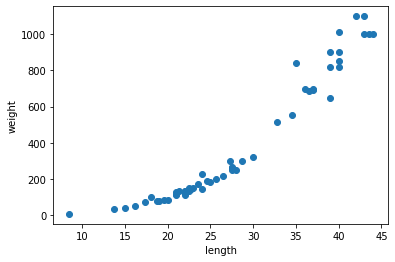

In [ ]:
# matplotlib으로 산점도 확인
import matplotlib.pyplot as plt
plt.scatter(perch_length, perch_weight)
plt.xlabel('length')
plt.ylabel('weight')
plt.show()

train_test_split의 인자로 주어진 perch_length와 perch_weight가 어떻게 작용하는가?

train_input, test_input, train_target, test_target 4개의 변수로 리턴하는데, 

이는 각각 perch_length의 train, test 와 perch_weight의 train, test를 의미한다.

길이를 토대로 무게를 예측해야 하므로 길이가 input, 무게가 target이 되므로!


In [ ]:
# 훈련 세트, 테스트 세트 분리
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(perch_length, perch_weight, random_state=42)

# 크기 확인 - 1차원 배열(벡터)
print(train_input.shape, test_input.shape, train_target.shape, test_target.shape)

(42,) (14,) (42,) (14,)


사이킷런에서 사용하는 훈련세트는 2차원 배열(행렬)이여야 하므로 수동으로 모양을 바꿔줄 필요가 있다.

-> reshape 함수 이용 : 인자로 배열의 크기를 넘겨줘야함

In [ ]:
# reshape에서 -1은 자동으로 채워지는 숫자
train_input = train_input.reshape(-1, 1) # = reshape(42, 1)
test_input = test_input.reshape(-1, 1) # = reshape(14, 1)
print(train_input.shape, test_input.shape)

(42, 1) (14, 1)


## 회귀 모델 평가 - 결정계수 ($R^2$), 평균 절댓값 오차

회귀에서 모델의 정확도를 평가하는 방법 : 결정계수 $R^2$

결정계수를 계산하는 방법 : $R^2 $= 1- {(타깃 - 예측)^2의 합 / (타깃 - 평균)^2의 합}

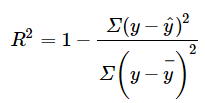

- 타깃에 가깝게 예측할 수록 분자가 작아지므로 결정계수는 1에 가까워진다.
- 평균을 예측하는 수준이라면 결정계수는 0에 가까운 값이 된다.
- 결정계수가 1에 가까울수록 성능이 좋고, 0에 가까울수록 성능이 안좋아진다.

분류의 경우 정답을 맞춘 갯수의 비율(정답/전체)를 score로 책정했지만, 회귀는 결정계수로 score를 책정한다.

In [ ]:
# k-최근접 이웃 회귀 모델 : KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor
knr = KNeighborsRegressor()

# 모델 훈련
knr.fit(train_input, train_target)

# 평가
knr.score(test_input, test_target)

0.9928094061010639

결정계수 $R^2$보다 직관적으로 오차를 알아내려면, 사이킷런에서 제공하는 mean_absolute_error을 사용하면 된다.

mean_absolute_error은 타깃과 예측의 **평균 절댓값 오차**를 반환한다.

-> 평균적으로 예측이 얼마나 빗나갔는지를 확인할 수 있음

In [ ]:
from sklearn.metrics import mean_absolute_error

# 예측 만들기
test_prediction = knr.predict(test_input)
# 평균 절댓값 오차를 계산 - mean_absolute_error
mae = mean_absolute_error(test_target, test_prediction)

print(mae)

19.157142857142862


## 과대적합 vs 과소적합

- **과대적합** - 훈련 세트에 대해 과도하게 학습된 상태.

    훈련 데이터에 대해 높은 점수가 나오지만, 테스트 데이터에서는 낮은 점수가 나오는 경우 
    
    기출문제만 50번을 풀어 새로운 유형에 대비하지 못하는 경우랑 비슷하다.

- **과소적합** - 훈련 세트에 적절히 훈련되지 않은 상태. 

    모델이 너무 단순하거나, 훈련 세트의 양이 적어서 발생함. 
    
    두 점수가 다 낮은 경우 또는 훈련 세트보다 테스트 세트의 점수가 더 높은 경우

    테스트 세트의 결과가 높게 나오다니 좋은거 아닌가? 라고 생각할 수 있지만, 
    
    훈련세트는 전체 데이터를 대표한다고 가정하기 때문에 
    테스트 세트 점수가 낮아지는 것을 감수하더라도 과소적합을 해결하는게 좋다.


In [ ]:
# 테스트세트 점수 훈련세트 점수가 더 낮은 과소적합 발생
knr.score(train_input, train_target)

0.9698823289099255

과소적합은 모델을 더 복잡하게 만듦으로서 해결할 수 있다.

-> k의 개수를 줄이면 국지적인 패턴에 민감해지게됨.

cf. 과대적합은 k의 개수를 늘려 모델을 단순화시킴으로서 해결할 수 있다.

In [ ]:
# 이웃의 갯수를 3으로 설정 (디폴트는 5)
knr.n_neighbors = 3

# 훈련
knr.fit(train_input, train_target)

# 평가
print('훈련 세트 :\t',knr.score(train_input, train_target),'\n테스트 세트 :\t',knr.score(test_input, test_target))
# 훈련세트의 점수가 테스트 세트보다 높아졌음을 확인할 수 있다.

훈련 세트 :	 0.9804899950518966 
테스트 세트 :	 0.974645996398761


## 확인 문제
k의 갯수를 조절하며 모델의 복잡도를 확인해보자.

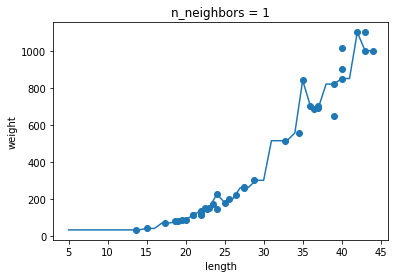

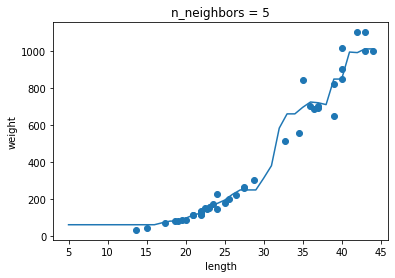

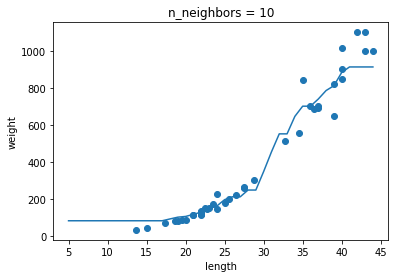

In [ ]:
# k-최근접 이웃 회귀 객체 생성
knr = KNeighborsRegressor()
# 5에서 44까지 x 좌표 생성
x = np.arange(5, 45).reshape(-1, 1) # -1은 40

# n = 1, 5, 10일 때 예측 결과를 그래프로 그립니다.
for n in [1, 5, 10]:
    # 모델 훈련
    knr.n_neighbors = n
    knr.fit(train_input, train_target)
    # 지정한 범위 x에 대한 예측 구하기 - 길이 x에 대한 무게를 예측
    prediction = knr.predict(x)
    # 훈련 세트 산점도로 표시하기
    plt.scatter(train_input, train_target)
    # input이 5-44일 때 예측 값 그래프로 구히기 
    plt.plot(x, prediction)
    plt.title('n_neighbors = {}'.format(n))    
    plt.xlabel('length')
    plt.ylabel('weight')
    plt.show()

# 산점도는 이미 존재하는 훈련 데이터, 그래프는 예측한 데이터
# k 가 커질수록 그래프가 부정확해짐을 확인할 수 있다.